In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
from IPython.display import display
import IPython
import cv2

In [186]:
data_folder = 'data'
data_file = 'ranzcr-clip-catheter-line-classification.zip'
file = Path('.') / data_folder / data_file

train_file = Path('.') / data_folder / 'train.csv'
train_annotations_file = Path('.') / data_folder / 'train_annotations.csv'



def series_counts(series: pd.Series, dropna: bool = False, sort_index=False) -> pd.DataFrame:
    """

    :param series:
    :param dropna:
    :param sort_index:
    :return:
    """
    if sort_index:
        df = pd.concat(
            [series.value_counts(dropna=dropna).sort_index().rename('count'),
             series.value_counts(dropna=dropna, normalize=True).sort_index().rename('% of total'),
             series.value_counts(dropna=dropna, normalize=True).sort_index().cumsum().rename('cumulative %')],
            axis=1)

    else:
        df = pd.concat(
            [series.value_counts(dropna=dropna).rename('count'),
             series.value_counts(dropna=dropna, normalize=True).rename('% of total'),
             series.value_counts(dropna=dropna, normalize=True).cumsum().rename('cumulative %')],
            axis=1)
    df.index.rename(series.name, inplace=True)
    return df


def get_annotations(img_id: str, file_path: Path = train_annotations_file) -> list:
    """Given an image id, returns a list of numpy arrays of the tube placement.

    :param img_id: A string of the image id.
    :param file_path: A Path of the train annotations file.
    :return: A list of numpy arrays of the tube placement.
    """
    df = pd.read_csv(file_path)
    data = df.loc[df.StudyInstanceUID == img_id, 'data']
    if data.empty:
        return []
    return [np.array(json.loads(row)) for row in data]


def plot_annotations(ax, annotations: list) -> None:
    """Given a matplotlib plot Axes and a list of numpy arrays of tube placements,
    Plots the tube placements on the axis.

    :param ax: matplotlib plot Axes
    :param annotations: A list of numpy arrays of the tube placement.
    """
    for annotation in annotations:
        ax.scatter(annotation[:, 0], annotation[:, 1])


def show_image(ax, image_id, folder=train_img_folder, data=train_df) -> None:
    """

    :param ax:
    :param image_id:
    :param folder:
    :param data:
    """
    image_file = folder / Path(f'{image_id}.jpg')
    img = cv2.imread(str(image_file))
    data_row = data.loc[data.StudyInstanceUID == image_id]
    ax.imshow(img)
    ax.set_title(get_record_info(data_row.iloc[0]))


def get_record_info(train_row) -> str:
    """

    :param train_row:
    :return:
    """
    patient_id = train_row.PatientID
    ett_fields = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']
    ngt_fields = ['NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal']
    cvc_fields = ['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']
    ett0, ett1, ett2 = [train_row[ett] for ett in ett_fields]
    ngt0, ngt1, ngt2, ngt3 = [train_row[ngt] for ngt in ngt_fields]
    cvc0, cvc1, cvc2 = [train_row[cvc] for cvc in cvc_fields]
    if not (ett0, ett1, ett2):
        ett = ''
    else:
        ett = f'Endotracheal tube: Abnormal - {ett0:,}; Borderline - {ett1:,}; Normal - {ett2:,}'

    if not (ngt0, ngt1, ngt2, ngt3):
        ngt = ''
    else:
        ngt = f'Nasogastric tube: Abnormal - {ngt0:,}; Borderline - {ngt1:,}; Incompletely Imaged {ngt2:,} Normal - {ngt3:,}'

    if not (cvc0, cvc1, cvc2):
        cvc = ''
    else:
        cvc = f'Central venous catheter tube: Abnormal - {cvc0:,}; Borderline - {cvc1:,}; Normal - {cvc2:,}'

    sgcp = train_row['Swan Ganz Catheter Present']
    if sgcp:
        sgcp_msg = f'\nSwan Ganz Catheter Present - {sgcp}'
    else:
        sgcp_msg = ''

    msg = [f'Patient id: {patient_id}', ett, ngt, cvc]
    return '\n'.join([m for m in msg if m]) + sgcp_msg


def plot_img(image_id: str,
             train_file: pd.DataFrame = train_df,
             annotations_path: Path = train_annotations_file,
             folder=train_img_folder,
             show_annotations=True,
             figsize=None,
             ax=None):
    figsize = (8, 8) if figsize is None else figsize
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    show_image(ax, image_id, folder=folder, data=train_file)

    if show_annotations:
        annotations = get_annotations(image_id, file_path=annotations_path)
        plot_annotations(ax, annotations)

    return ax

## trian.csv Columns:
    
    StudyInstanceUID - unique ID for each image
    ETT - Abnormal - endotracheal tube placement abnormal
    ETT - Borderline - endotracheal tube placement borderline abnormal
    ETT - Normal - endotracheal tube placement normal
    NGT - Abnormal - nasogastric tube placement abnormal
    NGT - Borderline - nasogastric tube placement borderline abnormal
    NGT - Incompletely Imaged - nasogastric tube placement inconclusive due to imaging
    NGT - Normal - nasogastric tube placement borderline normal
    CVC - Abnormal - central venous catheter placement abnormal
    CVC - Borderline - central venous catheter placement borderline abnormal
    CVC - Normal - central venous catheter placement normal
    Swan Ganz Catheter Present
    PatientID - unique ID for each patient in the dataset

In [187]:
train_df = pd.read_csv(train_file)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30083 entries, 0 to 30082
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   StudyInstanceUID            30083 non-null  object
 1   ETT - Abnormal              30083 non-null  int64 
 2   ETT - Borderline            30083 non-null  int64 
 3   ETT - Normal                30083 non-null  int64 
 4   NGT - Abnormal              30083 non-null  int64 
 5   NGT - Borderline            30083 non-null  int64 
 6   NGT - Incompletely Imaged   30083 non-null  int64 
 7   NGT - Normal                30083 non-null  int64 
 8   CVC - Abnormal              30083 non-null  int64 
 9   CVC - Borderline            30083 non-null  int64 
 10  CVC - Normal                30083 non-null  int64 
 11  Swan Ganz Catheter Present  30083 non-null  int64 
 12  PatientID                   30083 non-null  object
dtypes: int64(11), object(2)
memory usage: 3.0+ MB


In [188]:
train_df.nunique()

StudyInstanceUID              30083
ETT - Abnormal                    2
ETT - Borderline                  2
ETT - Normal                      2
NGT - Abnormal                    2
NGT - Borderline                  2
NGT - Incompletely Imaged         2
NGT - Normal                      2
CVC - Abnormal                    2
CVC - Borderline                  2
CVC - Normal                      2
Swan Ganz Catheter Present        2
PatientID                      3255
dtype: int64

In [189]:
train_annotations = pd.read_csv(train_annotations_file)
train_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17999 entries, 0 to 17998
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  17999 non-null  object
 1   label             17999 non-null  object
 2   data              17999 non-null  object
dtypes: object(3)
memory usage: 422.0+ KB


In [216]:
mean_df = train_df.mean()
mean_df

ETT - Abnormal                0.002626
ETT - Borderline              0.037829
ETT - Normal                  0.240667
NGT - Abnormal                0.009274
NGT - Borderline              0.017585
NGT - Incompletely Imaged     0.091347
NGT - Normal                  0.159459
CVC - Abnormal                0.106206
CVC - Borderline              0.281222
CVC - Normal                  0.708839
Swan Ganz Catheter Present    0.027590
dtype: float64

In [218]:
ett = train_df.filter(regex=(r'ETT')).copy()
ngt = train_df.filter(regex=(r'NGT')).copy()
cvc = train_df.filter(regex=(r'CVC')).copy()
sgcp = train_df.filter(regex=(r'Swan')).copy()

In [219]:
ett.mean()

ETT - Abnormal      0.002626
ETT - Borderline    0.037829
ETT - Normal        0.240667
dtype: float64

In [225]:
series_counts((ett).sum(axis=1))

count  % of total  cumulative %
0  21626    0.718878      0.718878
1   8457    0.281122      1.000000

In [239]:
len(ett.loc[ett.sum(axis=1) > 0]) / len(ett)

0.2811222285011468

In [220]:
ngt.mean()

NGT - Abnormal               0.009274
NGT - Borderline             0.017585
NGT - Incompletely Imaged    0.091347
NGT - Normal                 0.159459
dtype: float64

In [224]:
series_counts((ngt).sum(axis=1))

count  % of total  cumulative %
0  21775    0.723831      0.723831
1   8263    0.274673      0.998504
2     45    0.001496      1.000000

In [240]:
len(ett.loc[ngt.sum(axis=1) > 0]) / len(ngt)

0.27616926503340755

In [221]:
cvc.mean()

CVC - Abnormal      0.106206
CVC - Borderline    0.281222
CVC - Normal        0.708839
dtype: float64

In [226]:
series_counts((cvc).sum(axis=1))

count  % of total  cumulative %
1  25758    0.856231      0.856231
2   3504    0.116478      0.972709
0    750    0.024931      0.997640
3     71    0.002360      1.000000

In [241]:
len(cvc.loc[ngt.sum(axis=1) > 0]) / len(cvc)

0.27616926503340755

In [222]:
sgcp.mean()

Swan Ganz Catheter Present    0.02759
dtype: float64

### Not Normal Tube placement

In [206]:
bad_placement = train_df.filter(regex=(r'Abnormal|Borderline|Swan')).copy()
bad_placement['all'] = bad_placement.sum(axis=1)
series_counts(bad_placement['all'] == 0)

count  % of total  cumulative %
all                                   
True   17172    0.570821      0.570821
False  12911    0.429179      1.000000

Most of the records (almost 60%) are with only normal tube placement

In [207]:
series_counts(bad_placement['all'])

count  % of total  cumulative %
all                                 
0    17172    0.570821      0.570821
1    11456    0.380813      0.951634
2     1318    0.043812      0.995446
3      130    0.004321      0.999767
4        7    0.000233      1.000000

Most others has only one non normal tube placement

A Closer look at 4 non normal records:

In [208]:
multi_bad_placments = train_df.loc[bad_placement.loc[bad_placement['all'] == 4].index]
multi_bad_placments

StudyInstanceUID  ETT - Abnormal  \
191    1.2.826.0.1.3680043.8.498.83574817573978660270...               0   
3189   1.2.826.0.1.3680043.8.498.99236713642388770230...               0   
9008   1.2.826.0.1.3680043.8.498.11794944575870824563...               0   
9726   1.2.826.0.1.3680043.8.498.80790901319615385015...               0   
12088  1.2.826.0.1.3680043.8.498.84282327803734274858...               0   
16971  1.2.826.0.1.3680043.8.498.60265179180867198939...               0   
25765  1.2.826.0.1.3680043.8.498.20341712306663526872...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
191                   1             0               1                 1   
3189                  1             0               0                 0   
9008                  1             0               0                 0   
9726                  1             0               0                 1   
12088                 1             0               1                 0   
16971                 1             0               0                 0   
25765                 1             0               0                 1   

       NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
191                            0             0               0   
3189                           0             1               1   
9008                           0             1               1   
9726                           0             0               0   
12088                          0             0               0   
16971                          0             1               1   
25765                          0             0               0   

       CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  
191                   1             0                           0  f9691b393  
3189                  1             1                           1  d0e8c45f3  
9008                  1             1                           1  97389d001  
9726                  1             1                           1  ed56999f7  
12088                 1             0                           1  f26e165c6  
16971                 1             1                           1  ef58e1be9  
25765                 1             1                           1  ed56999f7

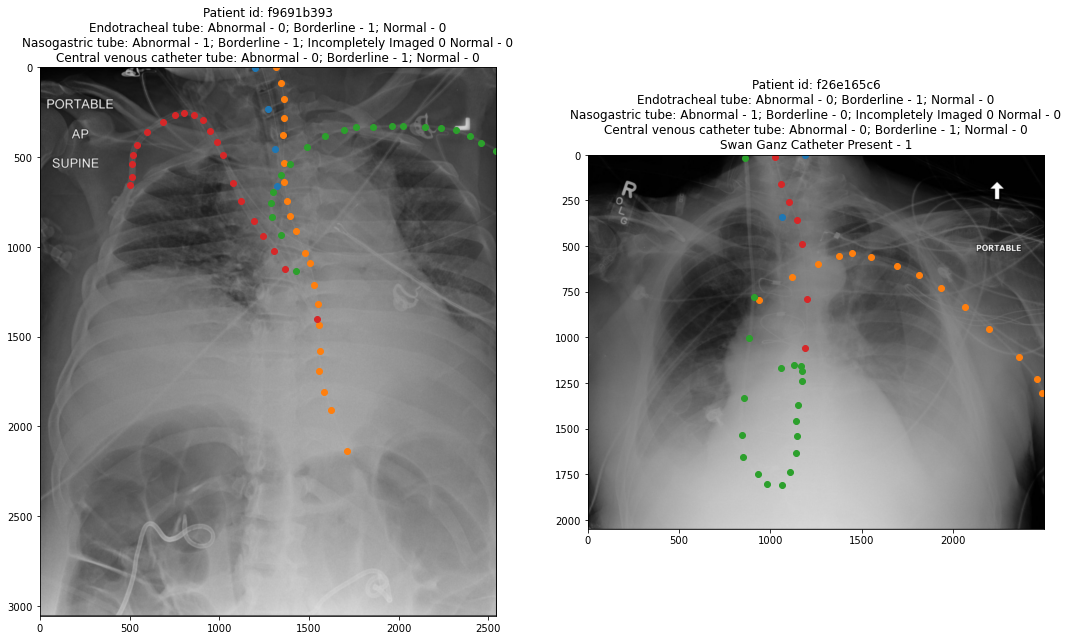

In [201]:
img1, img2 = multi_bad_placments.StudyInstanceUID.iloc[0], multi_bad_placments.StudyInstanceUID.iloc[4]
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot_img(img1, ax=ax[0])
plot_img(img2, ax=ax[1])
plt.show()

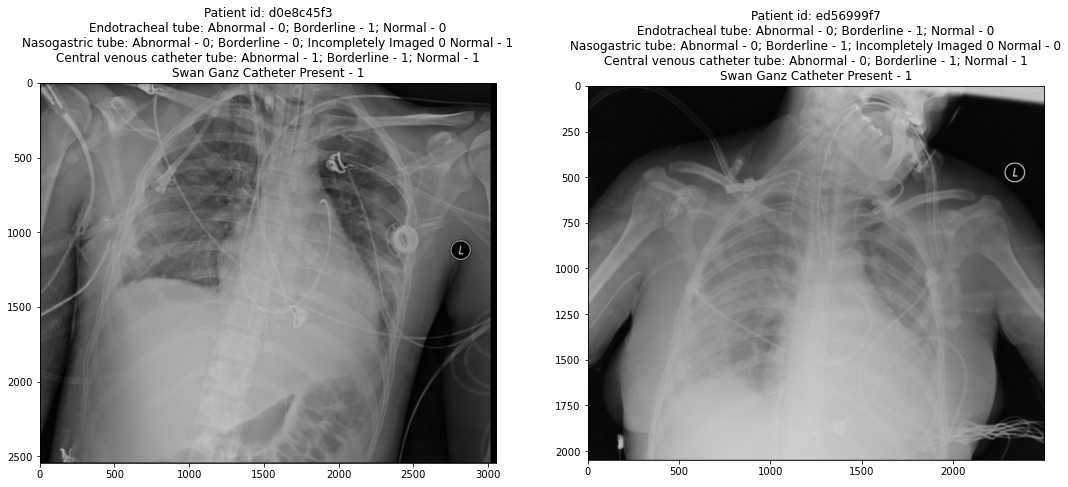

In [202]:
img1, img2 = multi_bad_placments.StudyInstanceUID.iloc[1], multi_bad_placments.StudyInstanceUID.iloc[3]
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot_img(img1, ax=ax[0], show_annotations=False)
plot_img(img2, ax=ax[1], show_annotations=False)
plt.show()

In [205]:
train_annotations.loc[train_annotations.StudyInstanceUID == img1]  ## Not all pics have annotations

Empty DataFrame
Columns: [StudyInstanceUID, label, data]
Index: []

In [231]:
ngt_multi = ngt.loc[ngt.sum(axis=1) > 1]
ngt_multi

NGT - Abnormal  NGT - Borderline  NGT - Incompletely Imaged  \
10                  1                 0                          0   
191                 1                 1                          0   
354                 0                 1                          1   
1552                0                 1                          0   
1884                0                 1                          0   
1890                0                 0                          1   
2083                1                 0                          1   
3319                1                 0                          1   
4368                0                 1                          0   
5016                1                 0                          0   
6966                0                 1                          0   
8091                1                 0                          1   
8951                0                 1                          0   
8987                1                 0                          1   
9246                1                 0                          0   
10789               0                 1                          0   
11597               1                 0                          0   
11632               1                 0                          0   
12178               0                 1                          0   
14103               1                 0                          1   
14851               0                 0                          1   
15077               0                 1                          0   
15321               0                 0                          1   
15682               0                 1                          0   
16160               1                 0                          0   
16695               1                 0                          1   
18161               0                 1                          1   
19822               1                 0                          0   
20575               0                 1                          0   
20956               0                 1                          1   
21722               0                 0                          1   
22204               0                 0                          1   
22519               1                 0                          1   
22712               1                 0                          1   
22955               1                 0                          0   
23133               0                 0                          1   
23606               1                 0                          1   
25220               1                 0                          0   
25855               0                 0                          1   
26956               0                 1                          1   
26967               0                 1                          0   
28182               0                 1                          0   
28355               1                 0                          1   
29176               0                 1                          0   
30045               0                 1                          1   

       NGT - Normal  
10                1  
191               0  
354               0  
1552              1  
1884              1  
1890              1  
2083              0  
3319              0  
4368              1  
5016              1  
6966              1  
8091              0  
8951              1  
8987              0  
9246              1  
10789             1  
11597             1  
11632             1  
12178             1  
14103             0  
14851             1  
15077             1  
15321             1  
15682             1  
16160             1  
16695             0  
18161             0  
19822             1  
20575             1  
20956             0  
21722             1  
22204             1  
22519             0  
22712             0  
22955           

C:\Users\adamr\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


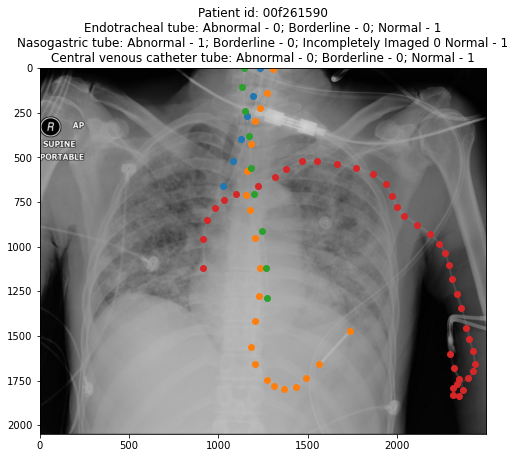

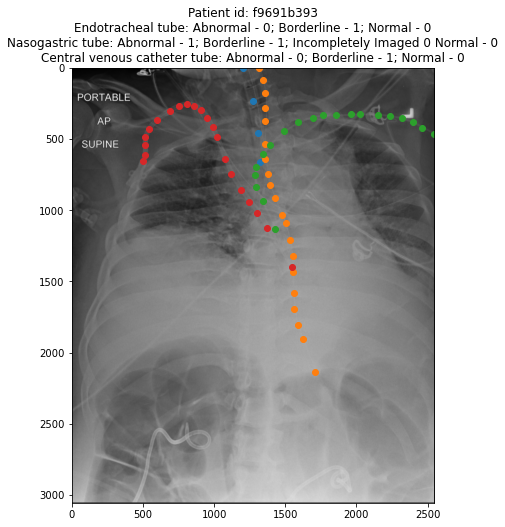

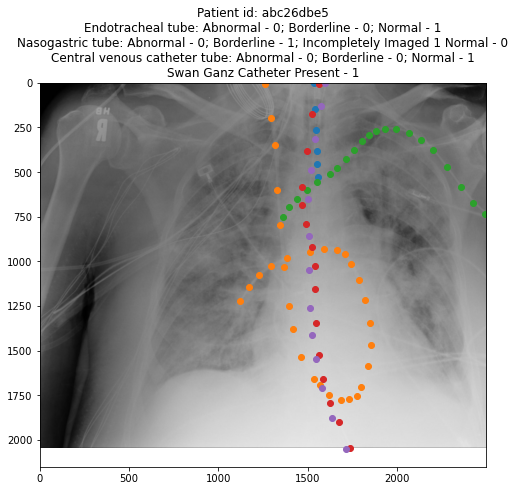

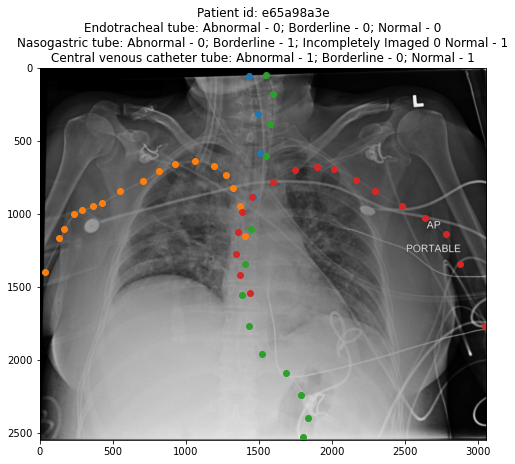

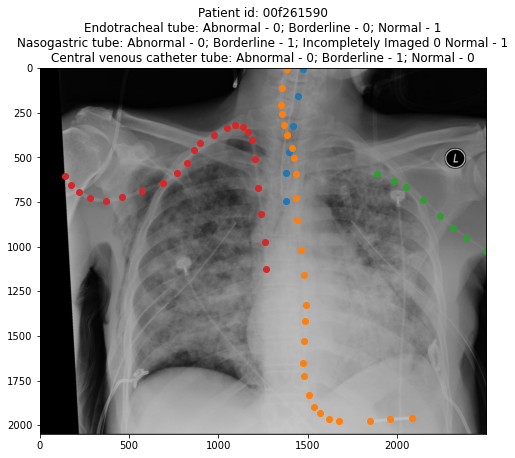

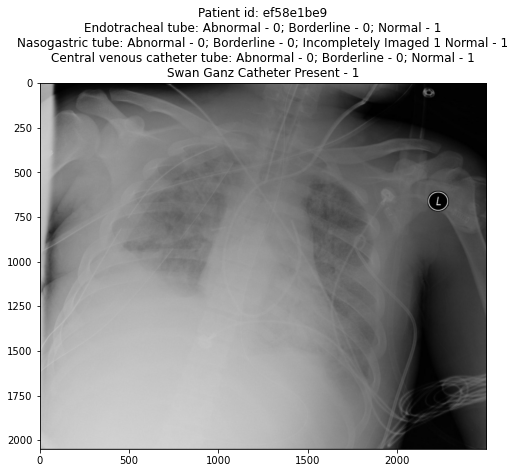

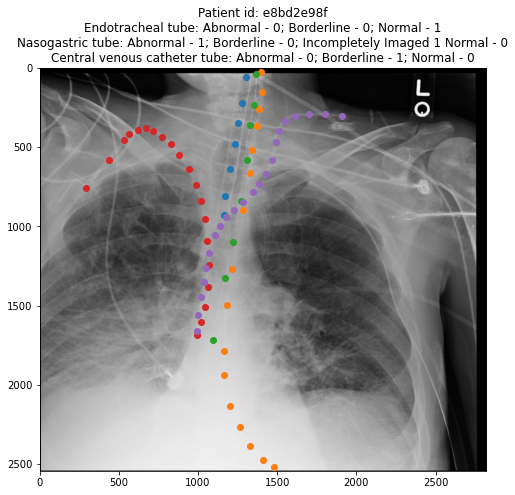

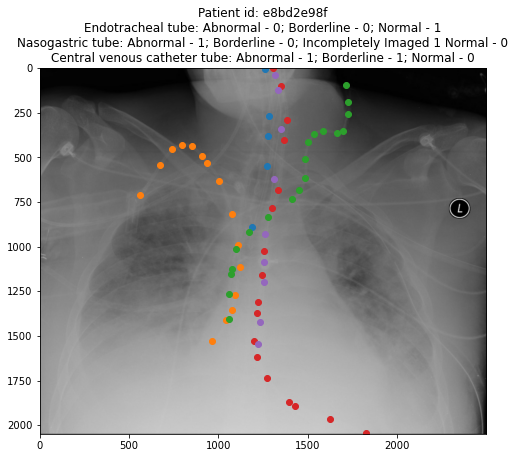

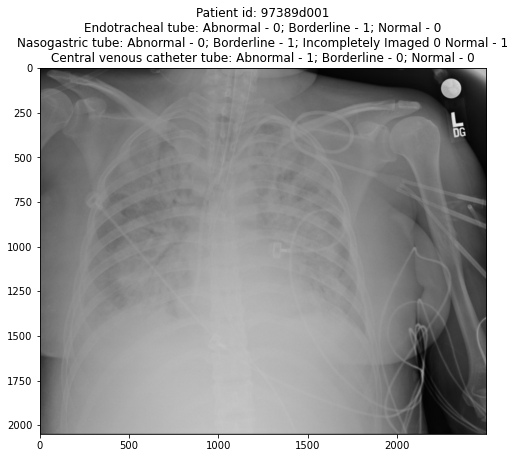

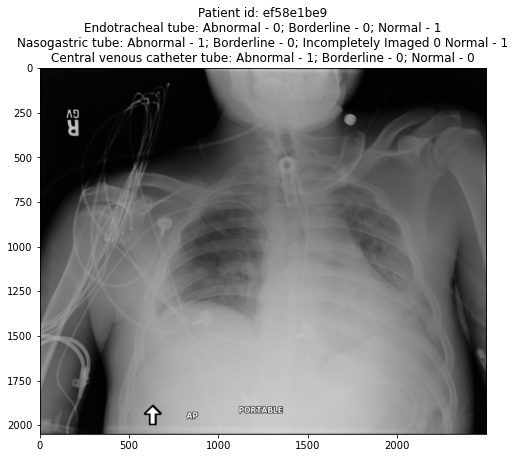

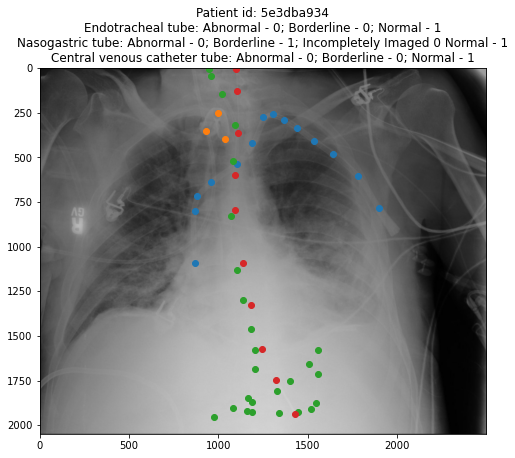

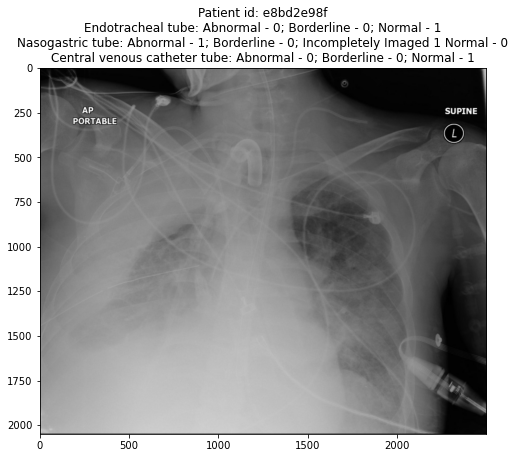

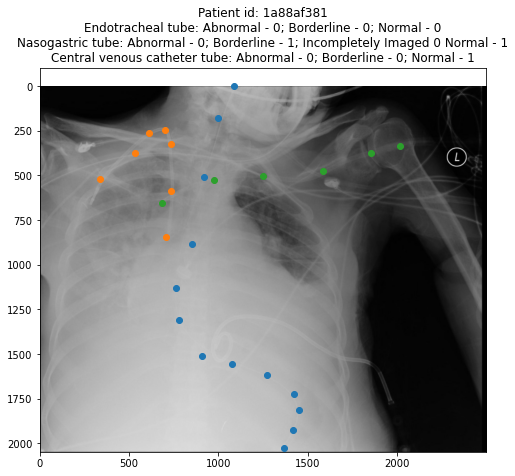

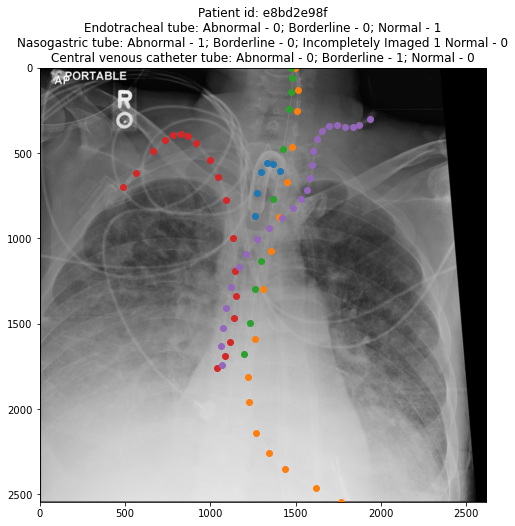

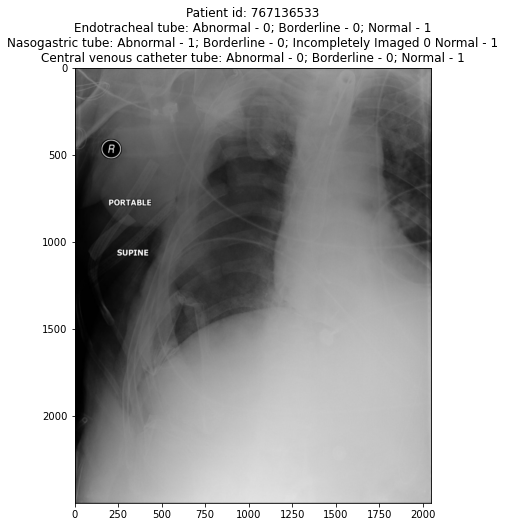

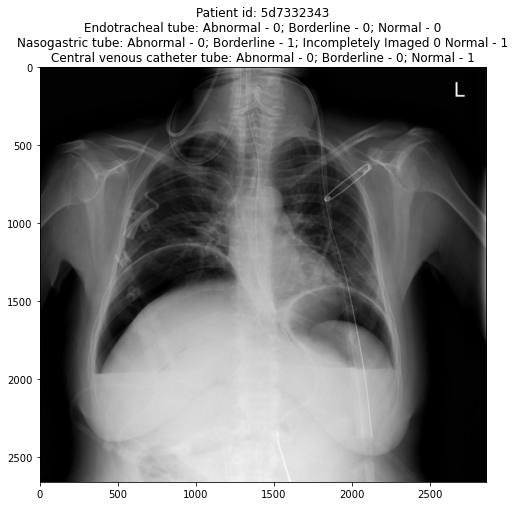

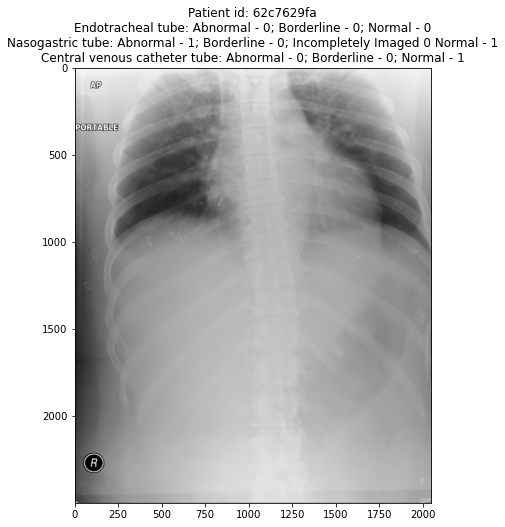

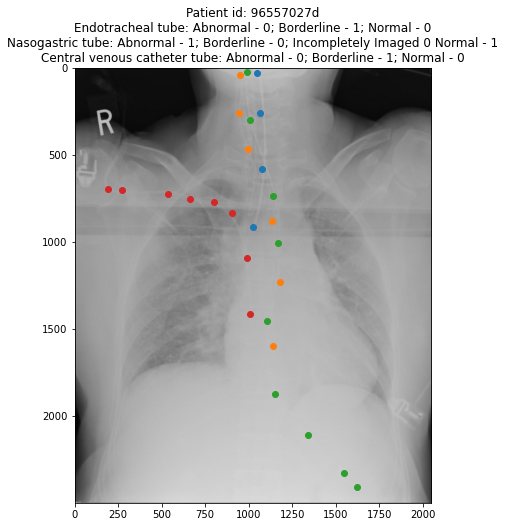

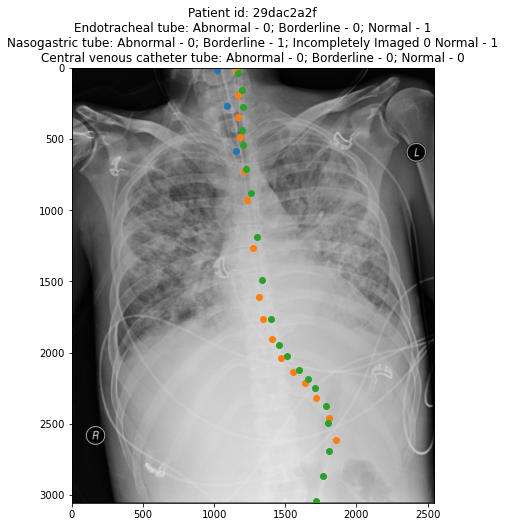

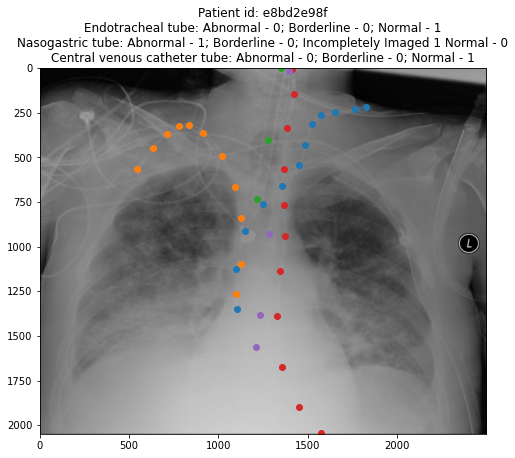

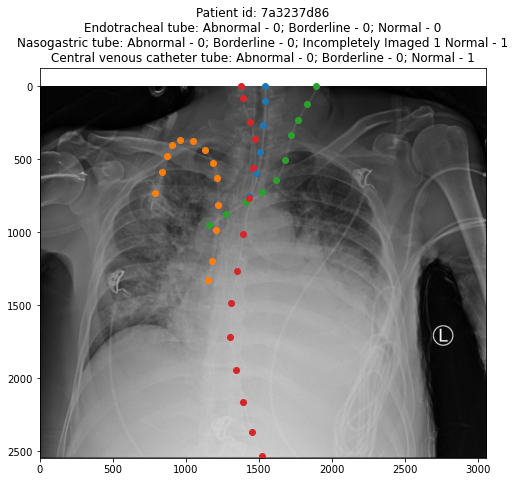

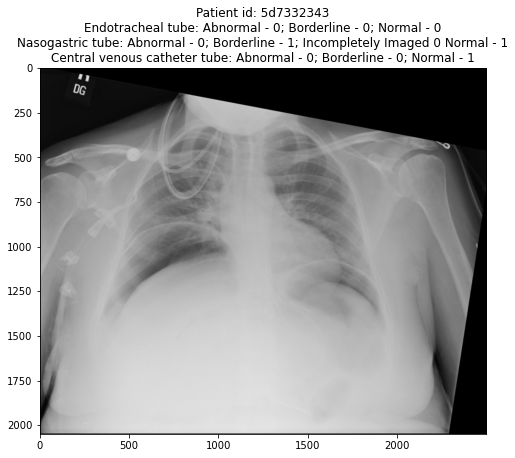

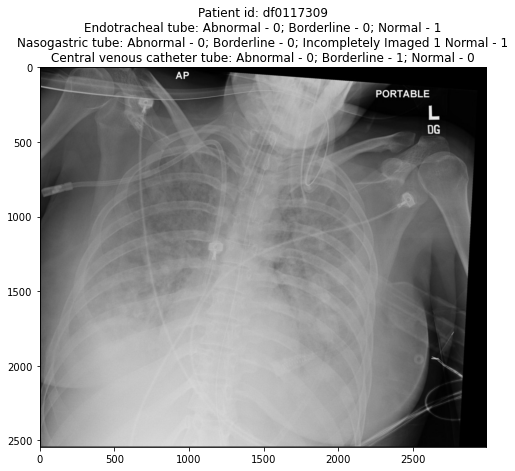

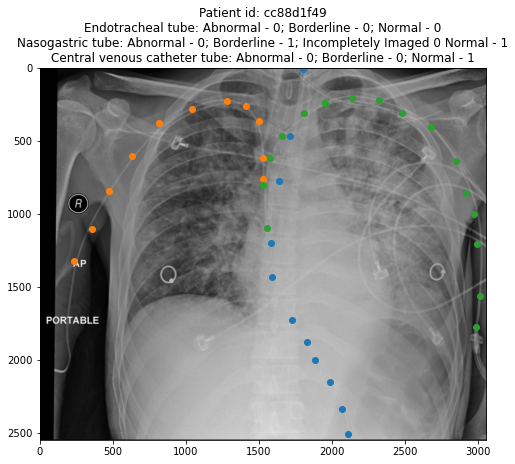

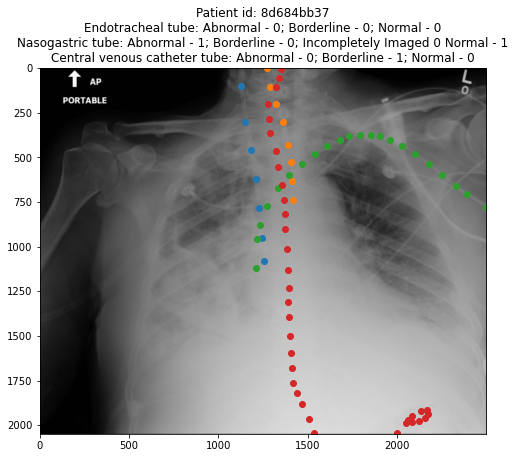

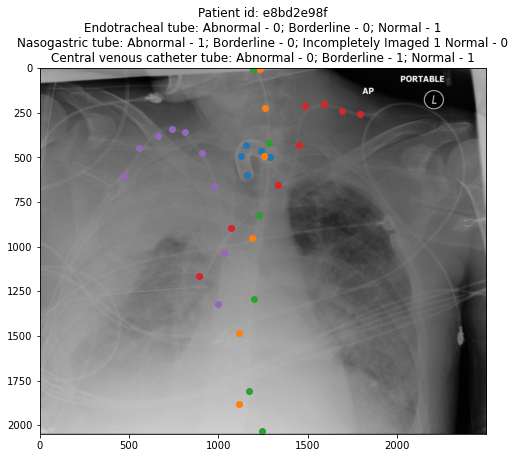

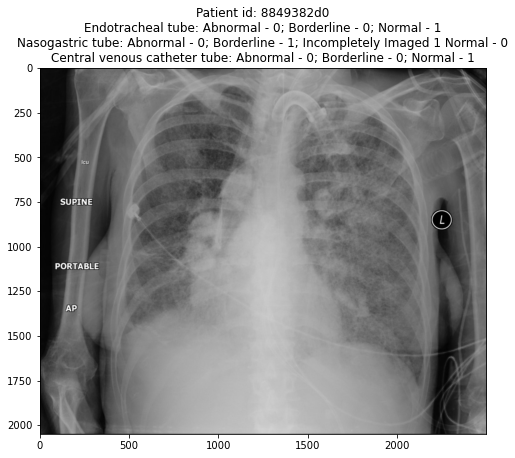

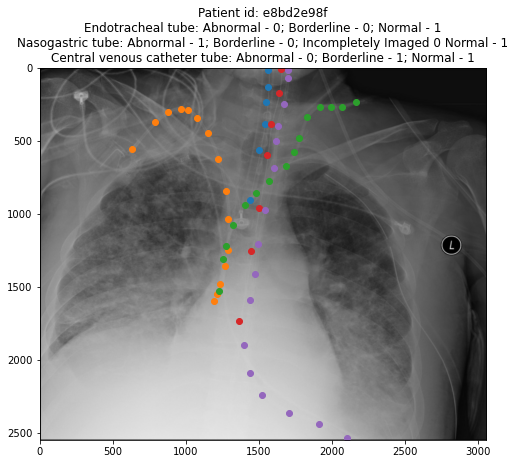

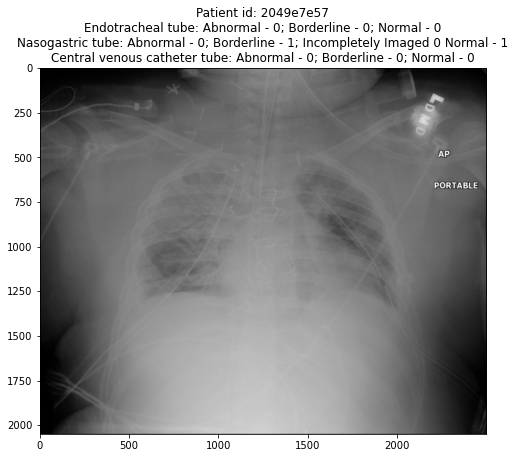

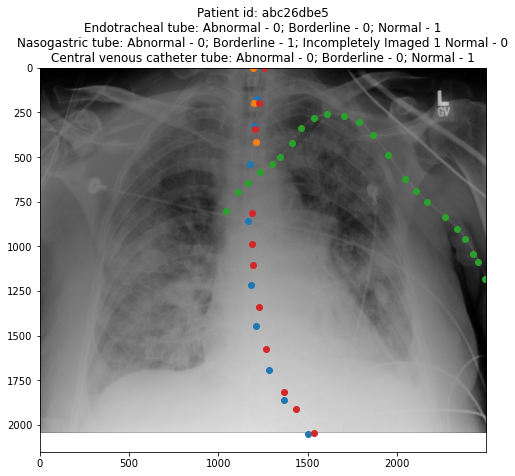

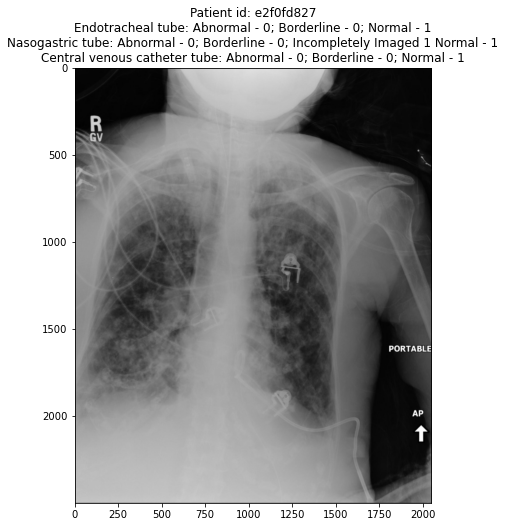

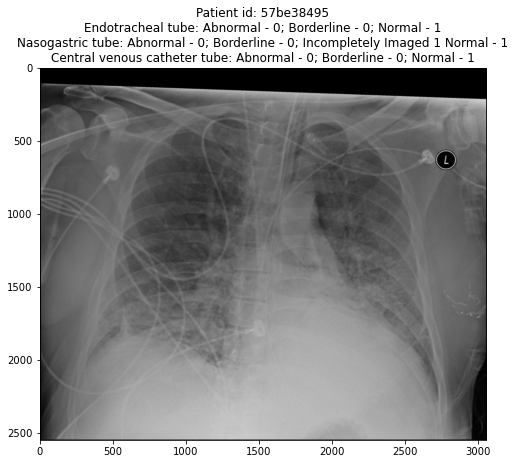

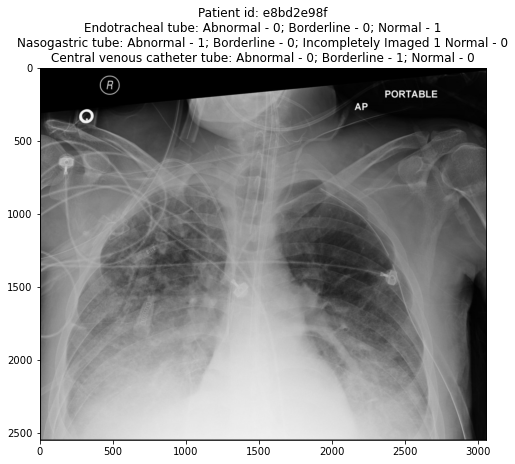

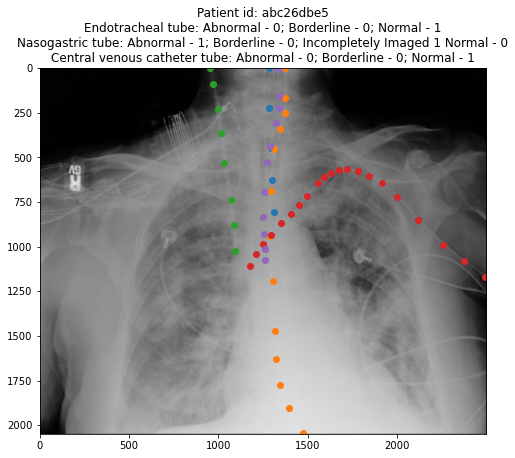

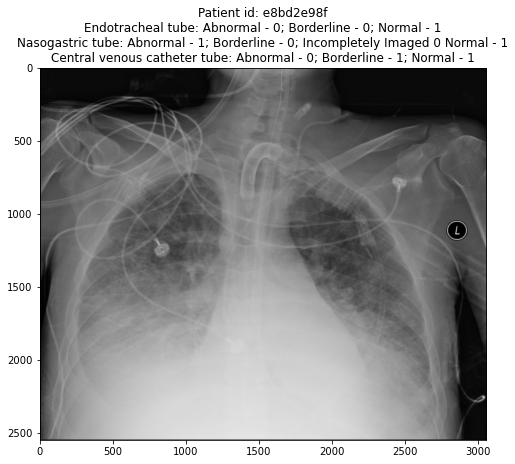

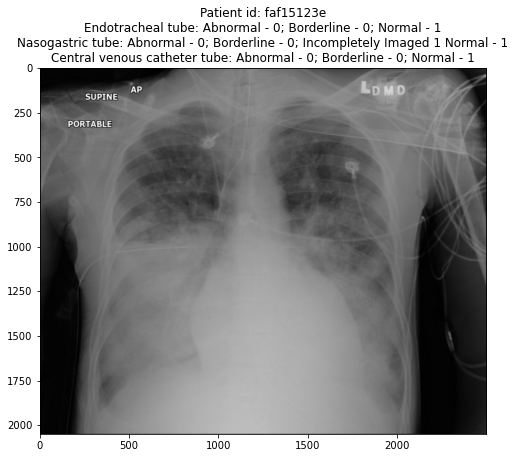

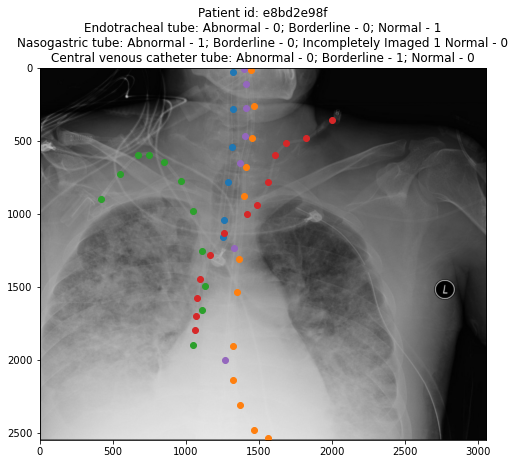

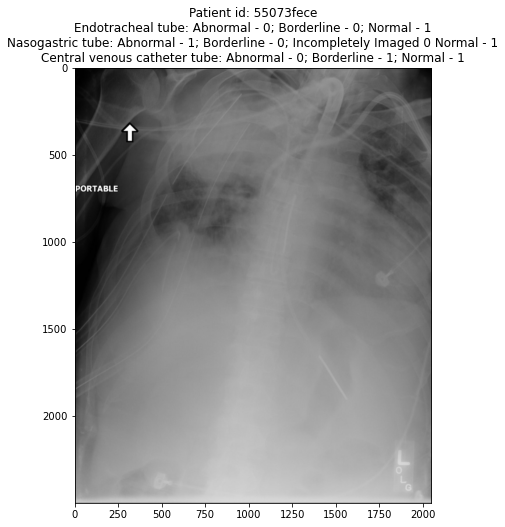

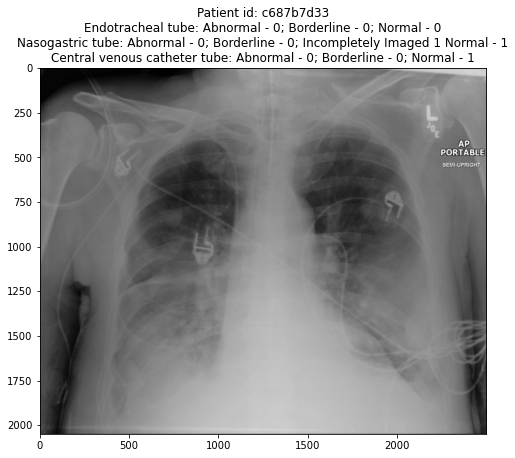

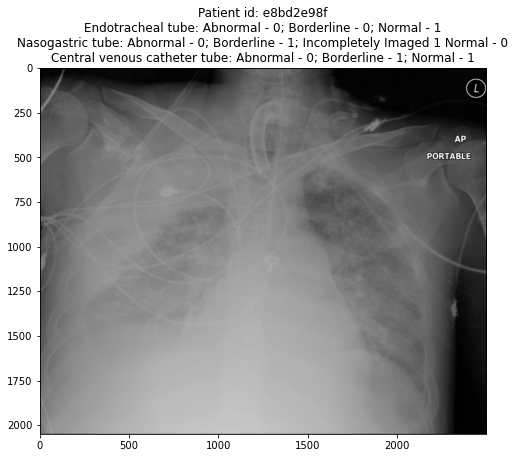

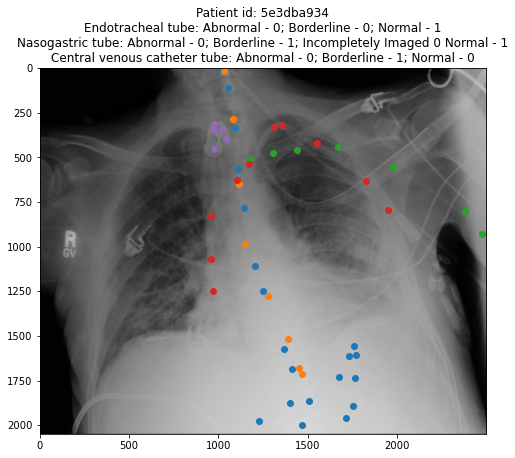

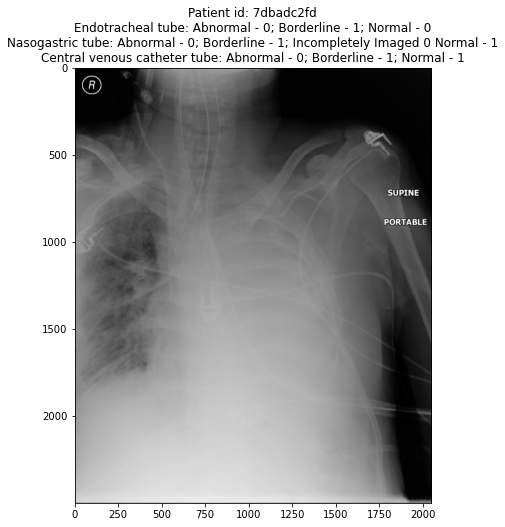

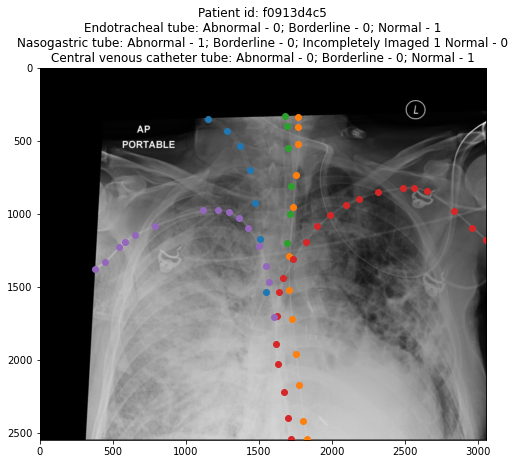

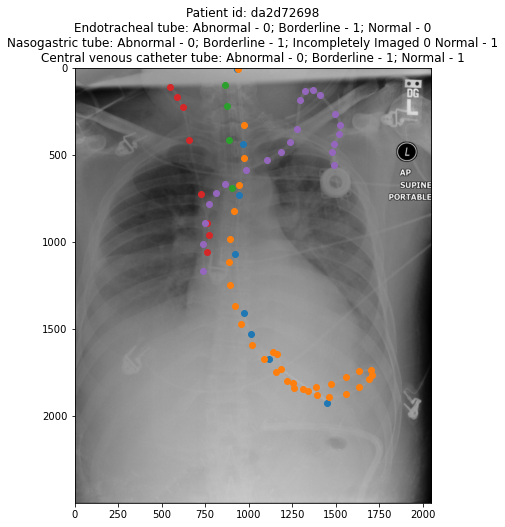

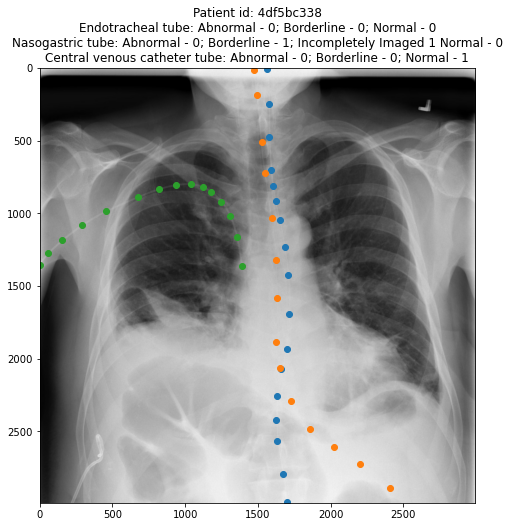

In [234]:
for i in ngt_multi.index:
    plot_img(train_df.loc[i].StudyInstanceUID)